## FCN (Fully Convolutional Network)

### 引入相關python模組

In [1]:
from mycnn import FCN8, FCN16, FCN32, FCN8_KERAS, FCN16_KERAS, FCN32_KERAS
from mycnn import data
from mycnn import losses
from mycnn import utils
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 自動建立VOC分割資料集

會自動在工作路徑底下建立資料夾，並建立相關的資料集檔案結構  
也會檢查路徑底下是否已經有建立完成檔案，避免重複下載及建立

In [2]:
data.download_pascal_voc_dataset(
    "./datasets"
)
data.make_voc_segment_dataset(
    "./datasets/VOC/VOCdevkit/VOC2012",
    "./datasets"
)

Already download tar file.
Already Uutar tar file.
Make some folders.
Get data list.
Already made dataset.


### 使用 `tf.data.Dataset` 來載入分割資料集

使用自建的 Dataset 實例來讀取影像、遮罩(mask)，並處理成 CNN 可以訓練的形式

```
mycnn.data.generate_segmentation_dataset

參數名稱            型態    說明
directory        : str   : 資料路徑 (子資料夾為類別)
image_size       : tuple : 影像大小
batch_size       : int   : 批次大小
subtract_mean    : float : 減去影像的均值，使其正規化
divide_stddev    : float : 除去影像標準差，使其正規化
shuffle_filepath : bool  : 打亂資料檔案路徑順序
shuffle_dataset  : bool  : 打亂資料讀取順序
validation_split : float : 分離驗證集的比例
```

In [3]:
train_dataset, valid_dataset = data.generate_segmentation_dataset(
    "./datasets/VOCSegmentation/train",
    image_size=(224,224),
    batch_size=10,
    subtract_mean=0,
    divide_stddev=255,
    shuffle_filepath=True,
    # shuffle_dataset=True,
    validation_split=0.1,
)
train_image_paths = train_dataset.image_paths
valid_image_paths = valid_dataset.image_paths
train_mask_paths = train_dataset.mask_paths
valid_mask_paths = valid_dataset.mask_paths

Read segmentation dataset.

Found 2913 image files and 2913.
Using 2621 files for training.
Using 292 files for validation.

train - RGB image - Not use data augmentation.
Rescale value to [0.0, 1.0].

valid - RGB image - Not use data augmentation.
Rescale value to [0.0, 1.0].


### 檢查原始資料

(10, 224, 224, 3)
(10, 50176, 21)


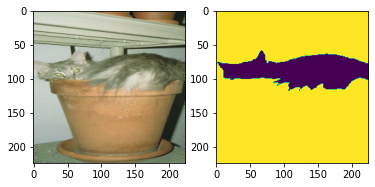

In [4]:
for i, m in train_dataset.take(1):
    bi = i
    bm = m
print(bi.shape)
print(bm.shape)

idx = 0
plt.subplot(121)
plt.imshow(bi[idx])
plt.subplot(122)
plt.imshow(bm.numpy().reshape(10,224,224,21)[idx,...,0])
plt.show()

### 載入模型

```
參數名稱       型態    說明
input_shape : tuple : 輸入影像形狀
classes_num : int   : 輸出類別數量
```

In [5]:
filters_list = [64,128,256,512,512,512]
# cnn = FCN32(classes_num=21, filters_list=filters_list)
cnn = FCN8(classes_num=21, filters_list=filters_list)
# cnn = FCN8_KERAS(classes_num=21, top_filters=512)
cnn.summary()

Model: "FCN8"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, 224, 224, 3)]      0             []                                      
                                                                                                                        
 block1_conv1 (Conv2D)                 (None, 224, 224, 64)       1792          ['image[0][0]']                         
                                                                                                                        
 block1_relu1 (ReLU)                   (None, 224, 224, 64)       0             ['block1_conv1[0][0]']                  
                                                                                                                        
 block1_conv2 (Con

### 配置訓練參數

```
參數名稱      型態                         說明
logdir     : str                        : 儲存路徑
epochs     : int                        : 訓練次數
batch_size : int                        : 批次大小 (註:此設定需與image_dataset_from_directory的批次大小一致)
optimizer  : str or tf.keras.optimizers : 優化函數
loss       : str or tf.keras.loss       : 損失函數
metrics    : list                       : 評估函數清單
```

In [6]:
cnn.setup_training(
    'log_fcn',
    epochs=100,
    batch_size=train_dataset.batch_size,  # batch size depend on ImageGenerator
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["Accuracy", losses.DiceLoss],
)

[Info] Create new the directory for training log !!!!!
******************************
Training new model...
******************************
checkpoint_path : log_fcn\weights
best_checkpoint : log_fcn\weights.h5
epochs          : 100
initial_epoch   : 0
batch_size      : 10
optimizer       : {'name': 'Adam', 'learning_rate': 0.0001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
loss            : categorical_crossentropy
metrics         : ['Accuracy', <function DiceLoss at 0x00000242DD3F9CA8>]


### 開始訓練

輸入參數分別為訓練資料集、驗證資料集的實例

In [7]:
cnn.train_dataset(train_dataset, valid_dataset)

Epoch 1/100
263/263 [==============================] - ETA: 0s - loss: 1.6167 - Accuracy: 0.6418 - DiceLoss: 0.5475
Epoch 00001: val_loss improved from inf to 1.26049, saving model to log_fcn\weights.h5
263/263 [==============================] - 51s 167ms/step - loss: 1.6167 - Accuracy: 0.6418 - DiceLoss: 0.5475 - val_loss: 1.2605 - val_Accuracy: 0.7385 - val_DiceLoss: 0.4446
Epoch 2/100
262/263 [============================>.] - ETA: 0s - loss: 1.2145 - Accuracy: 0.7494 - DiceLoss: 0.4124
Epoch 00002: val_loss improved from 1.26049 to 1.25109, saving model to log_fcn\weights.h5
263/263 [==============================] - 42s 160ms/step - loss: 1.2151 - Accuracy: 0.7493 - DiceLoss: 0.4129 - val_loss: 1.2511 - val_Accuracy: 0.7385 - val_DiceLoss: 0.4742
Epoch 3/100
263/263 [==============================] - ETA: 0s - loss: 1.1895 - Accuracy: 0.7493 - DiceLoss: 0.4047
Epoch 00003: val_loss improved from 1.25109 to 1.22760, saving model to log_fcn\weights.h5
263/263 [======================

### 繪製訓練過程曲線

可以用來確認權重是否有收斂的趨勢、檢查是否有過擬合狀況

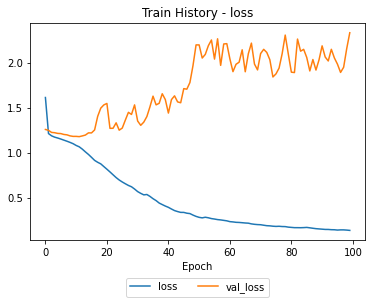

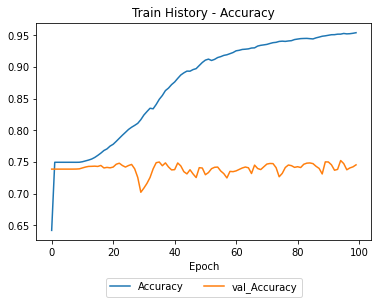

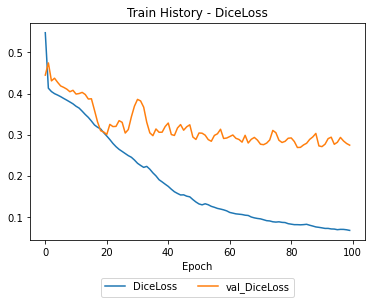

In [8]:
cnn.show_history(["loss", "Accuracy", "DiceLoss"])

### 使用測試資料來確認模型對於新資料的效能

In [9]:
cnn.eval_dataset(valid_dataset)

30/30 [==============================] - 2s 49ms/step - loss: 2.3388 - Accuracy: 0.7453 - DiceLoss: 0.2747


[2.338770866394043, 0.7452800273895264, 0.274671345949173]

### 預測單筆資料

./datasets/VOCSegmentation/train\images\2008_003858.jpg
./datasets/VOCSegmentation/train\images\2008_003858.jpg
(1, 224, 224, 3)
Choose -1: log_fcn\weights\weights.00100-2.3387709.h5

[Info] Use `tf.keras.Model` method predict



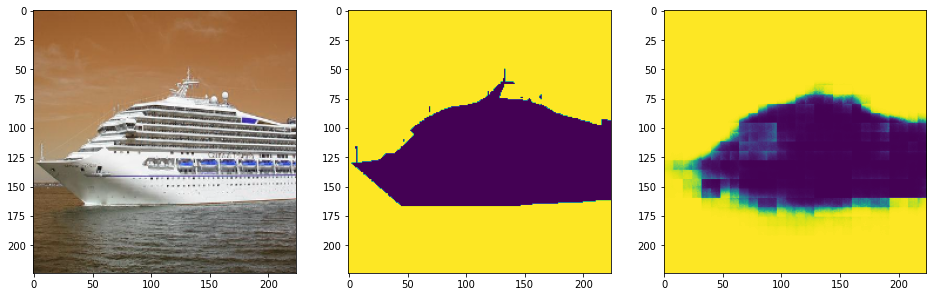

In [12]:
idx = 1

mask_size = (224, 224)

image_path = train_image_paths[idx]
mask_path = train_mask_paths[idx]
print(image_path)
print(image_path)

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, 0)

resized_image = cv2.resize(image, mask_size)
resized_mask = cv2.resize(mask, mask_size, interpolation=cv2.INTER_NEAREST).astype("uint8")
resized_mask = resized_mask.reshape((-1,))
resized_mask = np.eye(21).astype("uint8")[resized_mask]  # one-hot
resized_mask = resized_mask.reshape(1,224,224,21)

batch_one_image = np.expand_dims(resized_image, axis=0)
print(batch_one_image.shape)
cnn.load_checkpoint()
pr_sc = cnn.predict(batch_one_image/255.)
predicted_mask = pr_sc.reshape(1,224,224,21)

plt.figure(figsize=(16,32))
plt.subplot(131)
plt.imshow(resized_image)
plt.subplot(132)
plt.imshow(resized_mask[0,...,0])
plt.subplot(133)
plt.imshow(predicted_mask[0,...,0])
plt.show()